In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/philhoonoh/os/blob/main/lecture_summary/05_Chapter5.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View Source</a>
  </td>
</table>

# Chapter 6. Synchronization Tools
#### Contents
    - 6.1 Background
    - 6.2 The Critical Section Problem
    - 6.3 Software Solutions
    - 6.4 Hardware Support for Synchronization

# 6.1 Background

### Cooperating processes
- can either affect or be affected by each other.
- can share a logical address(thread) space or be allowed to share data (IPC - shared memory, message passing)  

  
- However, concurrent access to shared data may result in __data inconsistency__
- Hence, we need to ensure
    - the orderly execution of cooperating processes
    - that share a logical address space to __maintain data consistency__

### Integrity of data shared by several processes (or threads)
- __Concurrent execution__
    - a process may be interrupted at any point in its instruction stream
        - e.g. context switch
    - the processing core may be assigned to another process
    
    
- __Parallel executiong__
    - two or more instruction streams (representing different processes)
    - execute simultaneously on separate processing cores


### Example of how this is happen
- producer-consumer problem
    - where two processes share data and are running asynchronously
    - __Concurrent Execution__ 
        - context switch happens on __mahcine language level__...
        - which causes data inconsistency problem
    - __Parallel Execution__
        - tries to get share data at the same time 
        - which causes data inconsistency problem 


### __Solutions__ for data inconsistencies (will be further discussed)  

- Data Inconsistencies origingates from __Race Condition__
- How to solve __Race Condition?__

- Divide Sections ! (Critical Section Problem)
    - Three requirements : 
        1. Mutual Exclusion
        2. Progress 
        3. Bounded-Waiting
    - How?  
        a. soft-ware solutions
            - Peterson's solution
        b. hard-ware solutions
            - memory barriers or fences
            - create hardware instructions
            - set atmoic variables

### Example of __Concurrent Execution__ data inconsistency
- To count items in the buffer, add an integer variable _count_:
    - the processing core may be assigned to another process
    - initialized to 0,
    - incremented every time we add a new item to the buffer
    - decremented every time we remove one item from the buffer
    
```c
# Producer Part
while (true){
    /* produce an item in next_produces */
    while (count == BUFFER_SIZE)
        ; /* Do nothing */
    buffer[in] = next_produces;
    in = (in + 1) % BUFFER_SIZE;
    count++;
}

# Consumer Part
while (true) {
    while (count==0)
        ; /* do nothing */
    next_consumed = buffer[out];
    out = (out + 1) % BUFFER_SIZE;
    count--;
    /* consume the item in next_consumed */
}
```

- Although two processes are correct separately, they __may not function correctly__ when executed concurrently.
- Suppose that the value of count is currently 5,
    - the producer and consumer concurrently execute
    - two statements: count++; and count—;
    - the value of the variable count may be 4, 5, or 6!


### How these results can happen?
- Note that two statements “count++” and “count--” may be implemented in __machine language__ as follows:
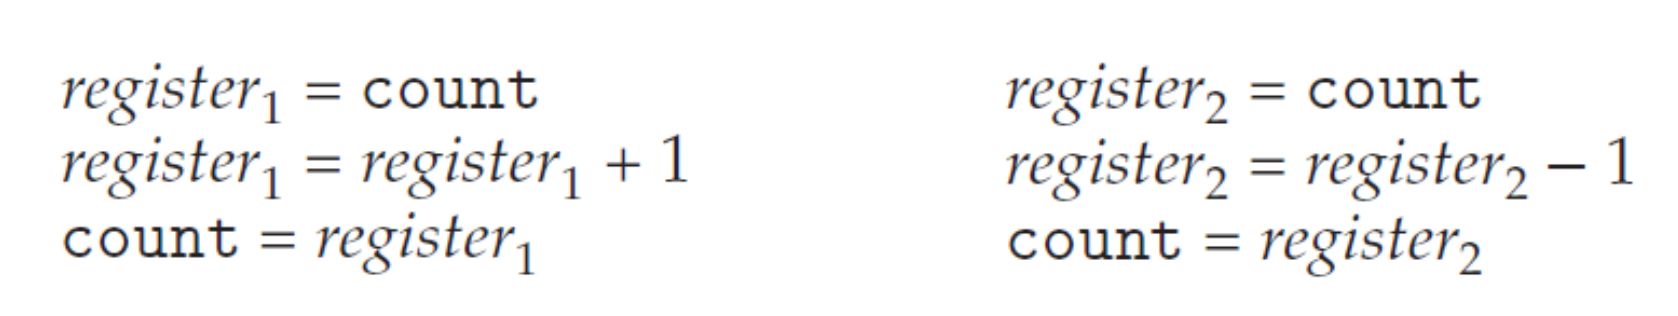

- Even though _resgister1_ and _register2_ may be the same physical register,
    - the contents of these registers will be saved and restored by the interrupt handler(or scheduler).

- The concurrent execution of “count++” and “count--”
    - is equivalent to a sequential execution
    - in which the lower-level statements presented previously
    - are __interleaved__ in some __arbitrary order__.
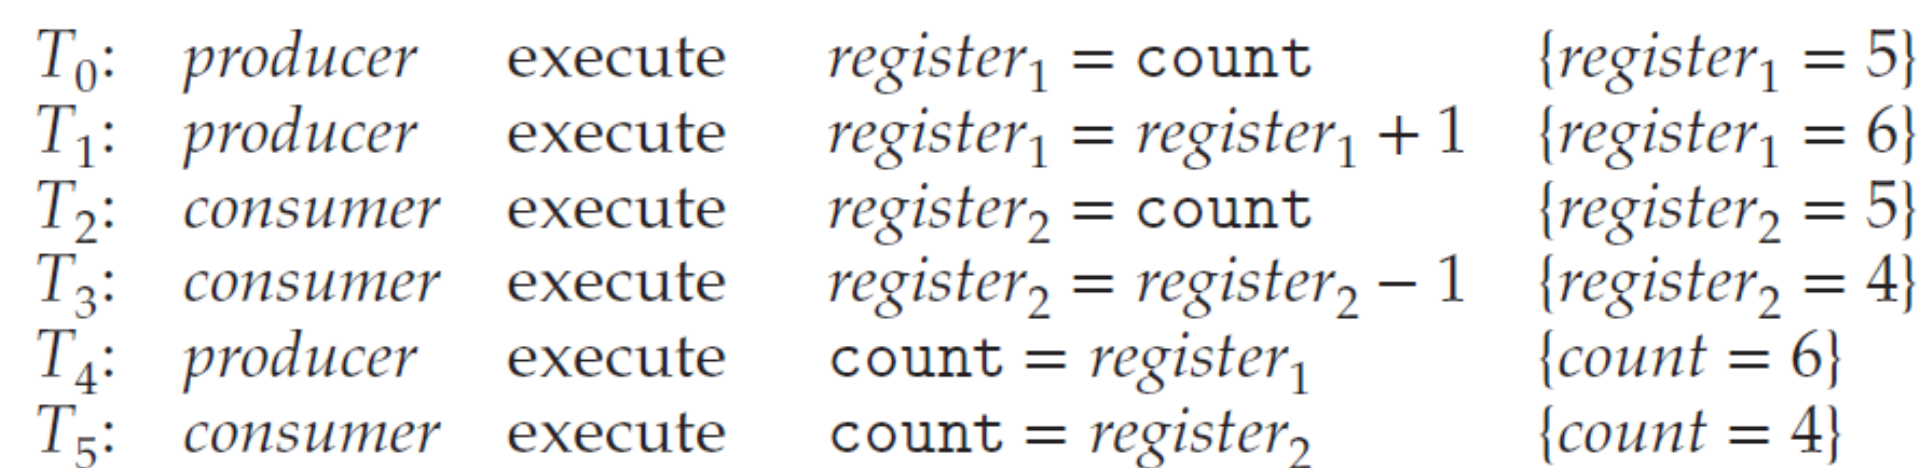

### Other Examples

#### Example 1
```c
#include <stdio.h>
#include <pthread.h>

int sum = 1;

void *run(void *param)
{
    int i;
    for (i = 0; i < 10000; i++) }
        sum++;
    pthread_exit(0);
}

int main() {
    pthread_t tid1, tid2;
    pthread_create(&tid1, NULL, run, NULL);
    pthread_create(&tid2, NULL, run, NULL);
    pthread_join(tid1, NULL);
    pthread_join(tid2, NULL);
    printf("%d\n", sum);
}
```

- Expected result is 20000
    - two threads sharing `sum`
    - increasing the sum by 10000 on each thread
- Actual result is not 20000

#### Example 2
```c
int sum;

void *run1(void *param)
{
    int i;
    for (i = 0; i < 10000; i++) }
        sum++;
    pthread_exit(0);
}

void *run2(void *param)
{
    int i;
    for (i = 0; i < 10000; i++) }
        sum--;
    pthread_exit(0);
}

int main() {
    pthread_t tid1, tid2;
    pthread_create(&tid1, NULL, run1, NULL);
    pthread_create(&tid2, NULL, run2, NULL);
    pthread_join(tid1, NULL);
    pthread_join(tid2, NULL);
    printf("%d\n", sum);
}
```
- Expected result is 0
    - two threads sharing `sum`
    - increasing the sum by 10000 and decreasing the sum by 10000 on each thread
- Actual result is not 0

### Race Condition
- where several processes (or threads) access and manipulate the same(or shared) data concurrently
- the outcome of the execution depends on the particular order in which the access takes place.

### Process (or thread) synchronization
- Prevent race condition
- only one process at a time can manipulate the shared data
    - e.g. the variable count 
    - require that the processes are synchronized in some way

### Race Condition in Java Threads Examples 
#### Example 1
```java
public class RaceCondition1 {

    public static void main(String[] args) throws Exception {
        RunnableOne run1 = new RunnableOne();
        RunnableOne run2 = new RunnableOne();
        
        Thread t1 = new Thread(run1);
        Thread t2 = new Thread(run2);
        t1.start(); t2.start();
        t1.join(); t2.join();
        System.out.println("Result: " + run1.count + ", " + run2.count);
    }
}

class RunnableOne implements Runnable {
    int count = 0;
    
    @Override
    public void run() {
        for (int i = 0; i < 10000; i++)
            count++;
    }
}
```

- Expected result is 20000
    - count is __not shared data__  
    - increasing the count in each class by 10000 on each thread
- Actual result is 20000
- __NOT Race Condition__

#### Example 2
```java
public class RaceCondition2 {

    public static void main(String[] args) throws Exception {
        RunnableTwo run1 = new RunnableTwo();
        RunnableTwo run2 = new RunnableTwo();
        Thread t1 = new Thread(run1);
        Thread t2 = new Thread(run2);
        t1.start(); t2.start();
        t1.join(); t2.join();
        System.out.println("Result: " + RunnableTwo.count);
    }
}

class RunnableTwo implements Runnable {
    static int count = 0;

    @Override
    public void run() {
        for (int i = 0; i < 10000; i++)
            count++;
    }
}
```
- Expected result is 20000
    - count is __shared data__ 
    - increasing the count by 10000 on each thread
- Actual result is not 20000
- __Race Condition__

# 6.2 The Critical Section Problem

### Critical Section 
- __a segment of code__ where the process may be _accessing_ & _updating_  data shared with at least one other process.

### Critical Section Problem
- Solution for _Race condition_
    - TLDF; divide sections related to shared data
- When one process is executing in its critical section, no other process is allowed to execute in its critical section.
- Meaning __No two processes are executing in their critical sections at the same time__
    
### Sections of codes
- __entry-section__
    - section of code requesting permission to enter its criticalsection
- __critical-section__
    - follows the entry-section
- __exit-section__
    - follows the critical-section
- __remainder-section__
    - section of remaining code
    
#### General structure of a typical process
```c
while (true) {
    entry section
        critical section
    
    exit section
        remainder section
}
```

### Solution for critical-section problem must satifisy the following requirements:

#### Mutual exclusion (상호배제) 
- If process Pi is executing in its critical section, then no other processes can be executing in their critical sections

#### Progress - (avoid deadlock)
- 두개 이상의 작업이 서로 상대방의 작업이 끝나기만을 기다리고 있는 상태 (asleep) 
- If no process is executing in its critical section and some processes wish to enter their critical sections, then only those processes that are not executing in their remainder sections can participate in deceding which will enter its critical section next, and this selection cannot be postponed indefinitely.

#### Bounded waiting - (avoid starvation)
- 프로세스의 우선순위가 낮아 자원을 계속 할당 받지 못하는 상태 (ready) 
- There exists a bound, or limit, on the number of times that other processes are allowed to enter their critical sections after a process has made a request to enter its critical section and before that request is granted.


#### Race Condition on Kernel Level
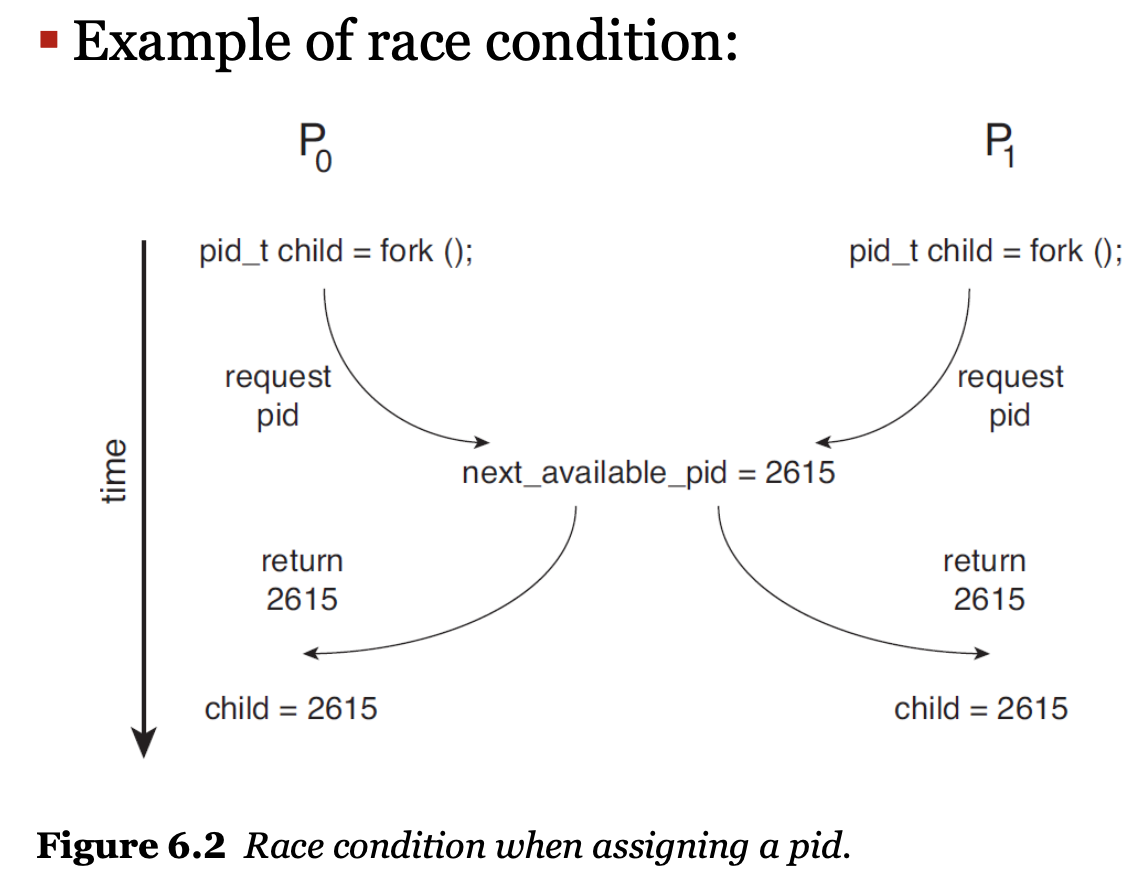

- Unless mutual exclusion is provided, it is possible the same process identifier number could be assigned to two separate processes.

### Solution for critical-section problem for single-core environment 
- __Prevent interrupts from occurring while a shared variable was being modified__
    - we could be sure that the current sequence of instructions would be allowed to execute in order without preemption
    - No other instructions would be run, so no unexpected modifications could be made to the shared variable

### Solution for critical-section problem for multiprocessor environment 
- _Prevent interrupts from occurring while a shared variable was being modified_ __not feasible__

### Two general approaches for critical-section problem
#### __preemptive kernels__
- A preemptive kernel allows a process to be preempted while it is running in kernel mode
- __not free from race conditions__
- Why using preemptive kernels?
    - more responsive
    - more suitable for real-time programming
    
#### __nonpreemptive kernels__
- A nonpreemptive kernel does not allow a process running in kernel mode to be preempted
- a kernel-mode process will run until it exits kernel mode, blocks, or voluntarily yields control of the CPU
- __essentially free from race conditions__ as only one process is active in the kernel at a time

# 6.3 Software Solutions

### Software Solutions to the Critical-Section Problem

- __Dekker’s Algorithm__
    - for two processes
    - flag, turn variables to decide which process(threads) enters the critical section
    - flag : process need to enter critical section
        - flag[0] = true -> process 0 wants to enter critical section
    - turn : order of process to enter critical section
        - turn = 0 -> turn for 0th process to enter critical section

```c
while(1){ // 프로세스i 의 진입 영역

    flag[i] = true; // 프로세스i 가 임계구역에 진입하기 위해 진입을 알림

    while(flag[j]) { // 프로세스j 가 임계구역에 진입하려고 하는지 확인
        if (turn == j) { // 프로세스 j가 임계구역에 있다면
            flag[i] = false;// 프로세스i가 진입을 취소하고
            
        while(turn == j); // 프로세스 i의 차례가 올 때까지 대기
      
        flag[i] =ture;     // 차례가 넘어왔다면 진입을 알림
    }
}

    // Critical Section
    
    turn = j; // 임계구역의 사용이 끝났다면 차례를 프로세스j에게 넘김.
    flag[i] = false; // 진입을 취소하여 임계구역 사용완료를 알림.
}
```


- __Peterson’s Algorithm__
    - for two processes (can extend to n processes) 
    - a classic software solution to the critical-section problem
   
```c
int turn;
boolean flag[2];

while(true){ // 프로세스 i의 진입 영역
    flag[i] = true; // 프로세스i 가 임계구역에 진입하기 위해 진입을 알림
    turn = j; // 프로세스j 가 임계구역에 있음을 가정(또는 프로세스 j에게 양보)
    
    while (flag[j] && turn == j); // 프로세스j 임계구역에 있을때 대기
    
    /* critical section*/
    
    flag[i] = false; // 프로세스i 가 진입을 취소, 임계구역 사용완료를 알림.
    
    /*remainder section*/
}
``` 


- __Eisenberg and McGuire’s Algorithm__
    - for 𝑛 processes with a lower bound on waiting of 𝑛 − 1 turns
    
    
- __Bakery Algorithm__
    - for 𝑛 processes 
    - distribute unique IDs to prcoesses(threads)
    - based on ID, set the priority(lower ID, comes first)
    - Process with lower ID enters Critical Section

```c
while(1){ // 프로세스i의 진입 영역
    choosing[i] = ture; // 번호표 받을 준비
    number[i] = max(number[0], number[1], ..., number[n-1]) + 1;  
    // 번호표 부여 
    // (번호표 부여중 선점이 되어 같은 번호를 부여 받는 프로세스가 발생할 수 있음)
    
    choosing[i] = false;  // 번호표를 받음

    for (j = 0; j < n; j++) { // 모드 프로세스와 번호표를 비교함.
        while (choosing[j]);    // 프로세스j가 번호표를 받을 때까지 대기
         
        while ((number[j] != 0) &&    
            ((number[j] < number[i])
            // 프로세스 j가 프로세스 i보다 번호표가 작거나(우선순위가 높고)
            || (number[j] == number[i] && j < i)); 
            // 또는 번호표가 같을 경우 j 가 i 보다 작다면 
            // 프로세스 j가 임계구역에서 나올 때까지 대기.     
    }

    // Critical Section
    number[i] = 0;  // 임계구역 사용완료를 알림.
}
```
 

[상호배제 여러가지 기법들 : SW solution](https://yoongrammer.tistory.com/61#%EC%83%81%ED%98%B8_%EB%B0%B0%EC%A0%9C_%EC%97%AC%EB%9F%AC_%EA%B0%80%EC%A7%80_%EA%B8%B0%EB%B2%95%EB%93%A4_:_SW_solution)

### Limitations on Software Solutions 
- Low Speed
- Hard to Code
- Busy Waiting (using loop for waiting) 
    - Can be advantage (referred as Spinlock)
- Premptive Kernels
    - __Software solution does not gurantee Mutual Exclusion on architecture using machine-language instructions, such as load and store__
        - Compilers might reorder operations 
        - Context Switch occur in machine language level
    - Can be solved by Hardware Instructions

### Peterson’s Algorithm
- no guarantees that Peterson’s solution will work correctly
    - Software solution does not gurantee Mutual Exclusion on architecture using machine-language instructions, such as load and store
        - Compilers might reorder operations 
        - Context Switch occur in machine language level
    
    
- Satisfy requirements of mutual exclusion, progress, and bounded waiting


- Peterson’s solution is provably correct.
    - __Mutual exclusion is preserved__
        - Note that each $P_{i}$ enters its critical section only if either flag[j]==false or turn==i.
    - The __progress requirement is satisfied__ (No deadlock)
    - The __bounded-waiting requirement is met__ (No starvation)

### Peterson’s solution Example

```c
#include <stdio.h>
#include <pthread.h>

#define true 1
#define false 0

int sum = 0;

int turn;
int flag[2];

int main()
{
    pthread_t tid1, tid2;
    pthread_create(&tid1, NULL, producer, NULL);
    pthread-create(&tid2, NULL, consumer, NULL);
    pthread_join(tid1, NULL);
    pthread_join(tid2, NULL);
    printf("sum = %d\n", sum)
}

void *producer(void *param){
    int k;
    for (k = 0; k < 10000; k++) {
        /* entry section */
        flag[0] = true;
        turn = 1;
        while (flag[1] && turn == 1);
        
        /* critical section */
        sum++;
        
        /* exit section */
        flag[0] = false;
        
        /* remainder section */
    }
    pthread_exit(0);
}

void *consumer(void *param){
    int k;
    for (k = 0; k < 10000; k++) {
        /* entry section */
        flag[1] = true;
        turn = 0;
        while (flag[0] && turn == 0);
        
        /* critical section */
        sum--;
        
        /* exit section */
        flag[1] = false;
        
        /* remainder section */
    }
    pthread_exit(0);
}

```

- Expected result is 0
- sum is shared data
- Actual result is not 0
- Not only Context Switch occur during __entry section__, but also can occur on __machine language level__

# 6.4 Hardware Support for Synchronization

### Hardware based solutions 
    - Provide support for solving the critical-section problem
    - Can be used directly as synchronization tools
    - Can be used to form the foundation of more abstract synchronization mechanisms

### Three primitive operations
    A. Memory Barriers (Memory Fences)
    B. Hardware Instructions
    C. Atomic Variables

### A. Memory Barriers (Memory Fences)
- Ensures that all loads and stores are completed before any subsequent load or store operations are performed

```c
/* Ensuring the value of flag loaded before the value of x */
while (!flag)
    memory_barrier();
print x;

/* Assignment to x occurs before the assignment to flag */
x = 100;
memory_barrier();
flag = true; 
```

### B. Hardware Instructions

- test and modify the content of a word or to swap the contents of two words __atomically (one uninterruptible unit)__

- __An atomic operation is one uninterruptible unit of operation__

- Define atomic instructions 
    - test_and_set() 
    - compare_and_swap()

#### test_and_set example
```c
/* Definition of the atomic test and set() instruction */
boolean test and set(boolean *target) {
    boolean rv = *target;
    *target = true;
    
    return rv;
}

/* Mutual-exclusion implementation with test and set() */
do {
    while (test_and_set(&lock)); /* do nothing */
    
    /* critical section */
    
    lock = false;
    
    /* remainer section */
} while (true);

```

#### compare_and_swap example
```c
/* Definition of the atomic compare_and_swap() instruction */
int compare_and_swap(int *value, int expected, int new value) {
    int temp = *value;

    if (*value == expected)
        *value = new value;
    return temp;
}

/* Mutual exclusion with the compare_and_swap() instruction */
while (true) {
    while (compare and swap(&lock, 0, 1) != 0); /* do nothing */
    

    /* critical section */
    
    lock = 0;
    
    /* remainer section */
}
```

### C. Atomic Variables
- provides atomic operations on basic data types such as integers and booleans
- ensure mutual exclusion in situations where there may be a data race on a single variable 


```c
void increment(atomic int *v)
{
    int temp;
    do {
        temp = *v;
    }
    while (temp != compare_and_swap(v, temp, temp+1));
}
```

### Java implementataion of Peterson’s solution 1

```java
public class Peterson1 {
    static int count = 0;
    
    static int turn = 0;
    static boolean[] flag = new boolean[2];
    
    static class Producer implements Runnable {
        @Override
        public void run() {
            for (int k = 0; k < 10000; k++) {
                /* entry section */
                flag[0] = true;
                turn = 1;
                while (flag[1] && turn == 1);

                /* critical section */
                count++;

                /* exit section */
                flag[0] = false;

                /* remainder section */
            }
        }
    }
    
    static class Consumer implements Runnable {
        @Override
        public void run() {
            for (int k = 0; k < 10000; k++) {
                /* entry section */
                flag[1] = true;
                turn = 0;
                while (flag[0] && turn == 0);

                /* critical section */
                count--;

                /* exit section */
                flag[1] = false;

                /* remainder section */
            } 
        }
    }

    public static void main(String[] args) throws Exception { 
        Thread t1 = new Thread(new Producer());
        Thread t2 = new Thread(new Consumer());
        t1.start(); t2.start();
        t1.join(); t2.join();
        System.out.println(Peterson1.count);
    }
}

```
- Expected Result is 0
- Actual Result is not 0
- Context Switch occurs on Entry Section

### Java implementataion of Peterson’s solution 2

```java

import java.util.concurrent.atomic.AtomicBoolean; 

public class Peterson2 {
    static int count = 0;
    
    static int turn = 0;
    static AtomicBoolean[] flag;
    
    static {
        flag = new AtomicBoolean[2];
        for (int i = 0; i < flag.length; i++)
            flag[i] = new AtomicBoolean();
    } 
    
    static class Producer implements Runnable {
        @Override
        public void run() {
            for (int k = 0; k < 100000; k++) {
                /* entry section */
                flag[0].set(true);
                turn = 1;
                while (flag[1].get() && turn == 1)
                    ;

                /* critical section */
                count++;

                /* exit section */
                flag[0].set(false);

                /* remainder section */
            } 
        }
    }
    
    static class Consumer implements Runnable {
        @Override
        public void run() {
            for (int k = 0; k < 100000; k++) {
                /* entry section */
                flag[1].set(true);
                turn = 0;
                while (flag[0].get() && turn == 0)
                    ;

                /* critical section */
                count--;

                /* exit section */
                flag[1].set(false);

                /* remainder section */
            } 
        }
    }  
    
    public static void main(String[] args) throws Exception { 
        Thread t1 = new Thread(new Producer());
        Thread t2 = new Thread(new Consumer());
        t1.start(); t2.start();
        t1.join(); t2.join();
        System.out.println(Peterson1.count);
    }
}

```
- Expected Result is 0
- Actual Result is 0
- Context Switch does not occur on entry section since elements of flag array is now atomic variabel